In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
# 1. Download Dataset
path = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Dataset path:", path)

100%|██████████| 218M/218M [00:02<00:00, 110MB/s] 

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


In [3]:
# Dataset structure after download:
# /cats_and_dogs/training_set/training_set/cats
# /cats_and_dogs/training_set/training_set/dogs
# /cats_and_dogs/test_set/test_set/cats
# /cats_and_dogs/test_set/test_set/dogs

In [4]:
train_dir = os.path.join(path, "training_set/training_set")
test_dir = os.path.join(path, "test_set/test_set")

In [5]:
img_size = (150, 150)
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode="binary", subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode="binary", subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode="binary", shuffle=False
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [8]:
# Model architecture (CNN)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# earlyStopping to stop training when the validation loss is not decreasing
# reduceLROnPlateau to reduce the learning rate when the validation loss is not decreasing
# modelCheckpoint to save the best model

earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
modelCheckpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[earlyStopping, reduceLROnPlateau, modelCheckpoint]
)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8280 - loss: 0.3868

201/201 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - accuracy: 0.8280 - loss: 0.3867 - val_accuracy: 0.7745 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8371 - loss: 0.3708

201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.8371 - loss: 0.3708 - val_accuracy: 0.8051 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8507 - loss: 0.3589

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8506 - loss: 0.3589 - val_accuracy: 0.8120 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8478 - loss: 0.3431

201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.8478 - loss: 0.3431 - val_accuracy: 0.8120 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8506 - loss: 0.3541

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8507 - loss: 0.3541 - val_accuracy: 0.8420 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8559 - loss: 0.3203

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.8559 - loss: 0.3204 - val_accuracy: 0.8482 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.8545 - loss: 0.3361 - val_accuracy: 0.8245 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8743 - loss: 0.3005

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8743 - loss: 0.3005 - val_accuracy: 0.8470 - val_loss: 0.3512 - learning_rate: 0.0010
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8781 - loss: 0.2934

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8781 - loss: 0.2935 - val_accuracy: 0.8463 - val_loss: 0.3466 - learning_rate: 0.0010
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8726 - loss: 0.2971

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.8726 - loss: 0.2971 - val_accuracy: 0.8563 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.8756 - loss: 0.2957 - val_accuracy: 0.8426 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 12/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.8768 - loss: 0.2974 - val_accuracy: 0.8282 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 13/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.8723 - loss: 0.2908 - val_accuracy: 0.8463 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 14/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8860 - loss: 0.2710

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.8860 - loss: 0.2710 - val_accuracy: 0.8557 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 15/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8882 - loss: 0.2726 - val_accuracy: 0.8445 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 16/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8885 - loss: 0.2656

201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8885 - loss: 0.2656 - val_accuracy: 0.8770 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 17/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.8875 - loss: 0.2675 - val_accuracy: 0.8401 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 18/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.8883 - loss: 0.2633 - val_accuracy: 0.8538 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 19/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.8954 - loss: 0.2595 - val_accuracy: 0.8470 - val_loss: 0.3417 - learning_rate: 0.0010
Epoch 20/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - accuracy: 0.9005 - loss: 0.2323 - val_accuracy: 0.8613 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 21/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9030 - loss: 0.2426 - val_accuracy: 0.8482 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 22/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9194 -

201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9202 - loss: 0.2036 - val_accuracy: 0.8732 - val_loss: 0.2957 - learning_rate: 2.0000e-04
Epoch 24/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.9182 - loss: 0.1873 - val_accuracy: 0.8707 - val_loss: 0.3250 - learning_rate: 2.0000e-04
Epoch 25/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9249 - loss: 0.1844 - val_accuracy: 0.8745 - val_loss: 0.3111 - learning_rate: 2.0000e-04
Epoch 26/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9285 - loss: 0.1800 - val_accuracy: 0.8801 - val_loss: 0.3008 - learning_rate: 2.0000e-04
Epoch 27/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.9332 - loss: 0.1714 - val_accuracy: 0.8819 - val_loss: 0.3097 - learning_rate: 2.0000e-04
Epoch 28/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9169 - loss: 0.1909 - val_accuracy: 0.8795 - val_loss: 0.3013 - learning_rate: 2.0000e-04
Epoch 29/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/s

201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - accuracy: 0.9368 - loss: 0.1523 - val_accuracy: 0.8826 - val_loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 39/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9375 - loss: 0.1608 - val_accuracy: 0.8788 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 40/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.9374 - loss: 0.1549 - val_accuracy: 0.8832 - val_loss: 0.3035 - learning_rate: 1.0000e-04
Epoch 41/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9377 - loss: 0.1649 - val_accuracy: 0.8844 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 42/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.9407 - loss: 0.1440 - val_accuracy: 0.8751 - val_loss: 0.3358 - learning_rate: 1.0000e-04
Epoch 43/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.9423 - loss: 0.1491 - val_accuracy: 0.8882 - val_loss: 0.2917 - learning_rate: 1.0000e-04
Epoch 44/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/s

In [14]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8860 - loss: 0.3616
Test Accuracy: 89.57%


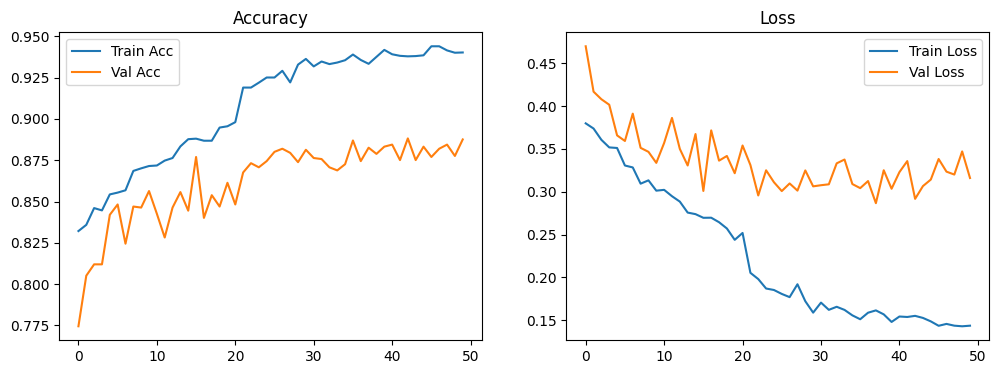

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [24]:
cat_test_path = os.path.join(test_dir, "cats")
dog_test_path = os.path.join(test_dir, "dogs")

In [32]:
from keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension

    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    print(f"Prediction: {label} ({prediction:.4f})")


predict_image(os.path.join(cat_test_path, os.listdir(cat_test_path)[0]))

predict_image(os.path.join(dog_test_path, os.listdir(dog_test_path)[1]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Cat (0.0347)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Cat (0.0024)
